# Quantifying blobs

Working off of 8/12 notebook, I have two related tasks here. 

The first is to count Rpb1 foci in a principled way. I got a ways down the road with this, but ultimately stalled at finding a reasonable way to threshold. This could use a lot more work.

The second is the modeling approach, where I try to recapitulate the blobs using a model. Visually it was easy to get this to look good (the simulated image looks, by eye, like the real data), but what does that mean? How can this information be useful? Two ideas were to try to fit the parameters of the model (not sure what the cost function is...) and to use the spot-counter (above) on simulated data to learn something about the spot counter. Not sure the wisdom of either approach.

I want to work on both these problems. First problem first.

In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import cv2 as cv

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2



## Blob counting

I'm gonna back up and look through some blob detection stuff online and see if I can get any good insights.

In [6]:
stack = blobdata[0].stack
nucmask = blobdata[0].nucmask

stack_x = np.where(nucmask, stack, 0)
test = stack_x[20]
fm.viewer(test, 5)

interactive(children=(Dropdown(description='Color', index=5, options=('gray_r', 'gray', 'inferno', 'Gators', '…

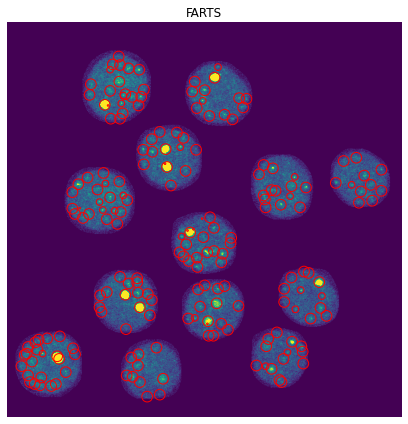

In [7]:
image = test.copy()
blobs_log = blob_dog(image, min_sigma=0.1, max_sigma=4, threshold=0.03)

fig, ax = plt.subplots(figsize=(18, 6), sharex=True, sharey=True)
#ax = axes.ravel()

ax.set_title('FARTS')
ax.imshow(image, vmax=100)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), 3*r, color=color, linewidth=1, fill=False)
    ax.add_patch(c)
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [36]:
stack = blobdata[0].stack
blobs_log = blob_dog(stack, min_sigma=0.1, max_sigma=4, threshold=0.03);
stack5d = np.expand_dims(stack, (0,1)).astype('uint16')
fm.quickview_ms2(stack5d, [blobs_log], MAX=False, halfwidth_z=0, shadows=False, figsize=6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray_r', 'gray', 'inferno', 'Gators', '…

## Impressions of blob finder

I think this is pretty decent. There's some variability, namely that the 0.03 threshold works pretty poorly for dataset 1 (but well for others). It's pretty sensitive to parameter tweaks in general. The only improvement over what I was doing is coneptual: I think the scale-space representation thing is good. But it overall suffers from the same problem: it's going to be impossible to find a single set of parameters (thresholds, etc) that work for all datasets.

I think the only workable strategy is going to be to try to collect a fairly large set of data under uniform conditions. Hopefully we can average out the variability and be left with some high quality results.

Let's try to put together a routine for a dataset using blobdog:

In [2]:
# Functions

@dataclass
class BlobStack:
    '''Class for keeping track of Blob stack processing.'''
    filepath: str
    stack: np.ndarray
    nucmask: np.ndarray
    detections: np.ndarray
    spot_counts: np.array

def count_spots_detections(detections, nucmask):
    nuc_ids = np.unique(nucmask)
    spot_counts = np.zeros(len(nuc_ids))

    for row in detections:
        coords = row[0:3]
        coords = tuple([int(x) for x in coords])
        nuc_id = nucmask[coords]
        spot_counts[nuc_id] += 1
    return spot_counts

def remove_edge_nuclei(nucmask, max_edge_pixels=0):
    new_mask = nucmask.copy()
    for nuc_id in np.unique(nucmask):
        z, i, j = np.where(nucmask == nuc_id)
        edgecount_i = np.count_nonzero(i == 0) + np.count_nonzero(i == (nucmask.shape[1] - 1))
        edgecount_j = np.count_nonzero(j == 0) + np.count_nonzero(j == (nucmask.shape[2] - 1))
        if ((edgecount_i + edgecount_j) > max_edge_pixels):
            new_mask[new_mask == nuc_id] = 0
    return new_mask

data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210913-rpb1blobdata.pkl')

In [8]:
data = []


In [51]:
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 10/embryo 5.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 10/emb 23.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo9b.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo11b.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo15.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo22.czi'
filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo36.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo3.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo6.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo17.czi'

stack = fm.read_czi(filepath, swapaxes=False)
if ((stack.shape[0] % 2) == 0):
    stack = stack[1:]

## Make nuclear mask

In [52]:
fm.viewer(stack, 6, zmax=True)
#fm.viewer(stack, 6)

interactive(children=(Dropdown(description='Color', index=8, options=('viridis', 'inferno', 'Greens', 'magma',…

In [53]:
nuc = fm.segment_nuclei_3Dstack_rpb1(stack, min_nuc_center_dist=55, sigma=5)

In [54]:
# nc11: 75000, 350000
nuc2 = fm.labelmask_filter_objsize(nuc, 75000, 350000)
fm.viewer(nuc2.max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=8, options=('viridis', 'inferno', 'Greens', 'magma',…

In [55]:
nuc3 = remove_edge_nuclei(nuc2)
nuc4 = fm.labelmask_apply_morphology(nuc3, ndi.morphology.binary_dilation, struct=np.ones((1,14,14)), expand_size=(2,15,15))
fm.viewer(np.where(nuc3, stack, 0).max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=8, options=('viridis', 'inferno', 'Greens', 'magma',…

In [57]:
nucmask = fm.relabel_labelmask(nuc4)

## Segment blobs, count

In [58]:
# Fix even/odd issue at stack level
detections = blob_dog(stack, min_sigma=0.1, max_sigma=5, threshold=0.02);
stack5d = np.expand_dims(stack, (0,1)).astype('uint16')
fm.quickview_ms2(stack5d, [detections], MAX=False, halfwidth_z=0, shadows=False, figsize=6)

interactive(children=(Dropdown(description='Color', index=8, options=('viridis', 'inferno', 'Greens', 'magma',…

In [59]:
spot_counts = count_spots_detections(detections, nucmask)

In [60]:
blobdata = BlobStack(filepath, stack, nucmask, detections, spot_counts)

In [61]:
data.append(blobdata)
del(filepath, stack, nucmask, detections, spot_counts)

In [62]:
fm.save_pickle(data, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210913-rpb1blobdata.pkl')

## Fucking with blobs

In [5]:
data

<module 'skimage.data' from '/Users/michaelstadler/opt/anaconda3/envs/im2/lib/python3.9/site-packages/skimage/data/__init__.py'>

In [8]:
blob = data[0]
detections = blob_dog(blob.stack, min_sigma=0.1, max_sigma=15, threshold=0.03);
stack5d = np.expand_dims(blob.stack, (0,1)).astype('uint16')
print(count_spots_detections(detections, blob.nucmask))


[616.  54.  46.  49.  67.  97. 122.  37.  79.  66.  82.  50.  80.  50.]


## Unhappy

### I just don't know if this is tweakable to the point of being reliable. I think to some degree we'll have to do it -- there's no choice but to try to count these things. The strategy I think will be:

- ### Collect consistent datasets on single embryos (multiple nuclear cycles from a single embryo).
- ### Find some set of reasonable settings for blob-calling.
- ### Normalize the datasets in some way, use the between-stage comparisons as the principle readout.

### I also think the complimentary strategy of modeling nuclei will be especially useful. Going to try to work on that now.

## Modeling

### Need a cost function. Once I have a cost function, I can play with the model and figure out how to run it in a reasonable amount of time to fit the parameters.

### I'm going to try some stuff. One possibility is to use a scale-space representation. My idea is to render scale space representations of the real stack and modeled stack and compare histograms of the individual slices (the different sigmas). The idea is that optimizing the model to equalize these histograms will capture intensity and spatial information. I'm not sure. Seems worth trying.

### It took some struggling to get opencv installed, but it seems to work. It has a histogram comparison function that seems reasonable. 

In [3]:
def make_scalespace(stack, sigmas):
    """Make a scalespace representation of an input stack using gaussian kernel with a range of sigmas."""
    dims = tuple([len(sigmas)]) + stack.shape
    scalespace = np.zeros(dims)
    for i in range(0, len(sigmas)):
        sigma = sigmas[i]
        scalespace[i] = ndi.gaussian_filter(stack, sigma)
    return scalespace

ss = make_scalespace(data[0].stack, np.arange(0, 5, 0.2))

In [11]:
nucmask = data[0].nucmask

In [6]:
fm.viewer(ss, 6)

interactive(children=(Dropdown(description='Color', index=9, options=('Reds', 'Gators', 'plasma', 'prism', 'in…

### The opencv calchist mask function has a weird flaw. If any row or column in the mask is all 0s, the whole histogram collapses to 0. No idea why that behavior would be a thing. What in the actual fuck? Whatever it just outputs an ndarray so I can use any hist function.

In [37]:
histSize = 256
histRange = (0, 100) # the upper boundary is exclusive
accumulate = False

hist_0 = cv.calcHist(ss.astype('uint8'), channels=[0], mask=None, histSize=[histSize], ranges=histRange, accumulate=False)
hist_1 = cv.calcHist(ss.astype('uint8'), channels=[1], mask=None, histSize=[histSize], ranges=histRange, accumulate=False)


In [47]:
hist_0 = np.histogram(ss[0][np.where(nucmask)], bins=256, range=(0,256))[0]
hist_0 = hist_0.astype('float32')

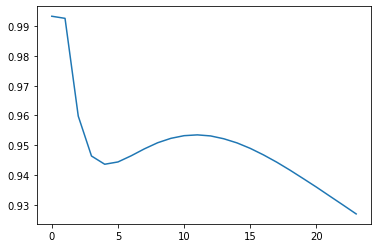

In [49]:
a = []
for i in range(1, 25):
    new_hist = np.histogram(ss[i][np.where(nucmask)], bins=256, range=(0,256))[0]
    new_hist = new_hist.astype('float32')
    a.append(cv.compareHist(hist_0, new_hist, method=cv.HISTCMP_CORREL))
plt.plot(a)

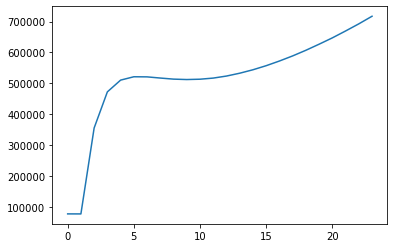

In [52]:
a = []
for i in range(1, 25):
    new_hist = np.histogram(ss[i][np.where(nucmask)], bins=256, range=(0,256))[0]
    new_hist = new_hist.astype('float32')
    a.append(cv.compareHist(hist_0, new_hist, method=cv.HISTCMP_CHISQR))
plt.plot(a)

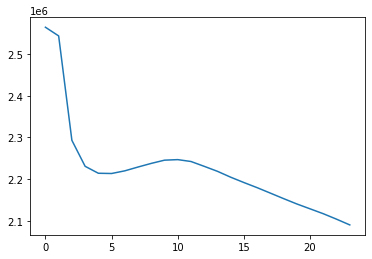

In [51]:
a = []
for i in range(1, 25):
    new_hist = np.histogram(ss[i][np.where(nucmask)], bins=256, range=(0,256))[0]
    new_hist = new_hist.astype('float32')
    a.append(cv.compareHist(hist_0, new_hist, method=cv.HISTCMP_INTERSECT))
plt.plot(a)

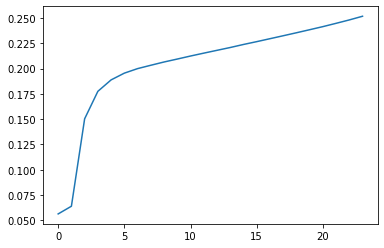

In [50]:
a = []
for i in range(1, 25):
    new_hist = np.histogram(ss[i][np.where(nucmask)], bins=256, range=(0,256))[0]
    new_hist = new_hist.astype('float32')
    a.append(cv.compareHist(hist_0, new_hist, method=cv.HISTCMP_BHATTACHARYYA))
plt.plot(a)

In [98]:
OPENCV_METHODS = (
("Correlation", cv.HISTCMP_CORREL),
("Chi-Squared", cv.HISTCMP_CHISQR),
("Intersection", cv.HISTCMP_INTERSECT),
("Hellinger", cv.HISTCMP_BHATTACHARYYA))

### Try some simulations with different properties and see how they compare to each other using the above analysis.

1. Write a function to do the above comparison with two stacks and a comparison function.
2. Simulate a few different things and see what the comparison yields.
3. Determine a metric (area under curve?)

In [102]:
def scalespace_hist_compare(stack1, stack2, method=cv.HISTCMP_BHATTACHARYYA, sigma_range=np.arange(0, 5, 0.2), mask1=None, mask2=None):
    def get_vals(stack, mask):
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()

    scalespace1 = make_scalespace(stack1, sigma_range) # 0, 5, 0.2
    scalespace2 = make_scalespace(stack2, sigma_range)
    comp_vals = []
    for i in range(0, scalespace1.shape[0]):
        vals1 = get_vals(scalespace1[i], mask1)
        vals2 = get_vals(scalespace2[i], mask2)
        hist1 = np.histogram(vals1, bins=256, range=(0,256))[0]
        hist2 = np.histogram(vals2, bins=256, range=(0,256))[0]
        comp_val = cv.compareHist(hist1.astype('float32'), hist2.astype('float32'), method=method)
        comp_vals.append(comp_val)
    return comp_vals

#scalespace_hist_compare(data[0].stack, data[1].stack, mask1=data[0].nucmask, mask2=data[1].nucmask)

In [66]:
from flymovie.fitting import gaussian3d

def make_3d_gauss_box(intensity, sigma_z, sigma_ij, z_winlen, ij_winlen):
    d1 = scipy.signal.gaussian(ij_winlen, sigma_ij)
    d2 = np.outer(d1, d1)
    z_1dvector = scipy.signal.gaussian(z_winlen, sigma_z)
    d3 = d2 * np.expand_dims(z_1dvector, axis=(1,2))
    return intensity * d3

bg_mean = 20
bg_sd = 2
def simulate(nucmask, bg_mean, bg_var, blob_intensity_mean, blob_intensity_var, blob_radius_mean, blob_radius_var, blob_number):
    def add_box(stack, box, coords):
        box_starts = []
        box_ends = []
        stack_starts = []
        stack_ends = []
        for dim in range(0, 3):
            start = coords[dim] - int(box.shape[dim] / 2)
            end = coords[dim] + int(box.shape[dim] / 2) + 1
            if start < 0:
                stack_starts.append(0)
                stack_ends.append(end + start)
                box_starts.append(-start)
                box_ends.append(box.shape[dim] + start)
            elif end > stack.shape[dim]:
                stack_starts.append(start)
                stack_ends.append(stack.shape[dim])
                box_starts.append(0)
                box_ends.append(box.shape[dim] + stack.shape[dim] - end)
            else:
                stack_starts.append(start)
                stack_ends.append(end)
                box_starts.append(0)
                box_ends.append(box.shape[dim])
        #box_to_add = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]]
        #stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]] += box_to_add
        #print(stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]].shape)
        #print(box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]].shape)
        #print(stack_starts)
        stackshape = stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]].shape
        boxshape = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]].shape
        if stackshape == boxshape:
            box_to_add = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[2]:box_ends[2]]
            stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[2]:stack_ends[2]] += box_to_add
        else:
            print('holla')

    # Must be odd
    z_windowlen = 5
    ij_windowlen = 21
    bg_stack = np.random.normal(bg_mean, bg_var, size=nucmask.shape)
    simstack = np.where(nucmask, bg_stack, 0)
    for nuc_id in np.unique(nucmask)[1:]:
    #for nuc_id in range(0,1):
        nuc_coords = np.where(nucmask == nuc_id)
        nuc_numpixels = len(nuc_coords[0])
        for n in range(0, blob_number):
            r_ij = np.random.normal(blob_radius_mean, blob_radius_var)
            r_z = r_ij / 2
            intensity = np.random.normal(blob_intensity_mean, blob_intensity_var)
            
            rand_pixel_num = np.random.randint(0, nuc_numpixels - 1)
            z, i, j = nuc_coords[0][rand_pixel_num], nuc_coords[1][rand_pixel_num], nuc_coords[2][rand_pixel_num]
            gaussian_function = gaussian3d(z, i, j, intensity, r_z, r_ij, r_ij)
            box = make_3d_gauss_box(intensity, r_z, r_ij, z_windowlen, ij_windowlen)
            add_box(simstack, box, (z, i, j))
    return simstack            
    


In [69]:
mask = data[1].nucmask

sim1 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=35, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=250)
sim2 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=35, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=250)

sim3 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=70, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=450)
sim4 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=70, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=450)



In [72]:
a12 = scalespace_hist_compare(sim1, sim2, mask1=mask, mask2=mask)
a13 = scalespace_hist_compare(sim1, sim3, mask1=mask, mask2=mask)
a14 = scalespace_hist_compare(sim1, sim4, mask1=mask, mask2=mask)

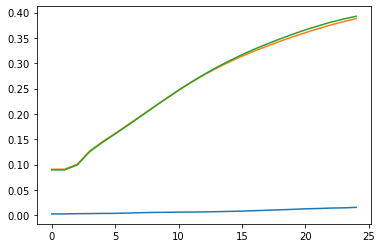

In [73]:
plt.plot(a12)
plt.plot(a13)
plt.plot(a14)

In [77]:
b1 = scalespace_hist_compare(sim1, data[1].stack, mask1=mask, mask2=mask)
b2 = scalespace_hist_compare(sim3, data[1].stack, mask1=mask, mask2=mask)

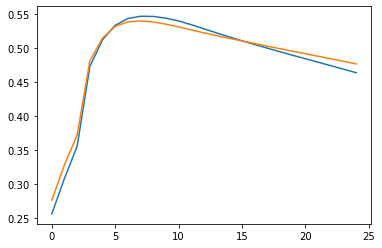

In [78]:
plt.plot(b1)
plt.plot(b2)

In [79]:
sim5 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=70, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=10)


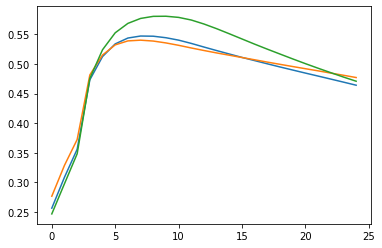

In [80]:
b3 = scalespace_hist_compare(sim5, data[1].stack, mask1=mask, mask2=mask)
plt.plot(b1)
plt.plot(b2)
plt.plot(b3)

In [101]:
# Change blob number:
blob_nums = [50, 100, 200, 400]
sims = []
for i in range(0, 4):
    blob_num = blob_nums[i]
    sim = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=35, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=blob_num)
    sims.append(sim)

stats = np.zeros((4,4))
for i in range(0, 4):
    for j in range(0, 4):
        stats[i,j] = np.sum(scalespace_hist_compare(sims[i], sims[j], mask1=mask, mask2=mask))

KeyboardInterrupt: 

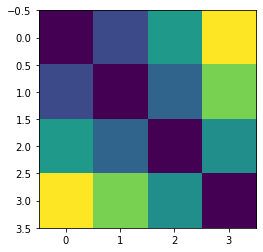

In [98]:
plt.imshow(stats)

In [99]:
# Change blob intensity:
blob_intensity = [20, 40, 100, 200]
sims = []
for i in range(0, 4):
    blob_num = blob_nums[i]
    sim = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=blob_intensity[i], blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=100)
    sims.append(sim)

stats = np.zeros((4,4))
for i in range(0, 4):
    for j in range(0, 4):
        stats[i,j] = np.sum(scalespace_hist_compare(sims[i], sims[j], mask1=mask, mask2=mask))

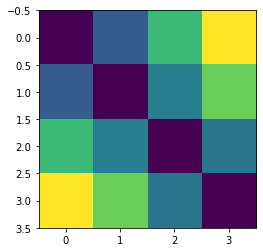

In [100]:
plt.imshow(stats)

### This is promising. I tried changing blob number and blob intensity, generating a series of images increasing in either. The challenge is to find a similarity metric that captures these differences. Here, I tried first creating a scale-space representation of each image, then comparing the histograms for each sigma layer using the opencv histogram compare function. Doing a pairwise comparison using the sum of all the histogram comparison scores (essentially AUC), I get the heatmaps above.

### That seems awfully complicated, but it did at least work. The scale-space histogram comparison gives correct relationships using simulated data. A few issues.

- ### There are still parameters to tweak (which histogram comparison function?).
- ### It's very slow. As written above, it computes the scalespace representation many unnecessary times, so that could help. It's also possible to use a less detailed scale-space model (fewer sigmas). 

### What I need is to write the cost function. It would take an input scale-space representation (SSR) of the real stack and some simulation parameters and return the AUC of the histocompare function. Then I can tweak how I do that and try to make it go faster.

In [113]:
def scalespace_hist_compare(scalespace1, scalespace2, method=cv.HISTCMP_BHATTACHARYYA, sigma_range=np.arange(0, 5, 0.2), mask1=None, mask2=None):
    def get_vals(stack, mask):
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()

    comp_vals = []
    for i in range(0, scalespace1.shape[0]):
        vals1 = get_vals(scalespace1[i], mask1)
        vals2 = get_vals(scalespace2[i], mask2)
        hist1 = np.histogram(vals1, bins=256, range=(0,256))[0]
        hist2 = np.histogram(vals2, bins=256, range=(0,256))[0]
        comp_val = cv.compareHist(hist1.astype('float32'), hist2.astype('float32'), method=method)
        comp_vals.append(comp_val)
    return comp_vals

def sim_and_histcomp(scalespace_input, method=cv.HISTCMP_BHATTACHARYYA, mask=None, sigma_range=np.arange(0, 5, 0.2), bg_mean=28, 
    bg_var=9, blob_intensity_mean=30, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=100):
    
    sim = simulate(mask, bg_mean=bg_mean, bg_var=bg_var, blob_intensity_mean=blob_intensity_mean, blob_intensity_var=blob_intensity_var, 
        blob_radius_mean=blob_radius_mean, blob_radius_var=blob_radius_var, blob_number=blob_number)
    
    sim_scalespace = make_scalespace(sim, sigma_range)
    hist_comp = scalespace_hist_compare(scalespace_input, sim_scalespace, mask1=mask, mask2=mask)
    return hist_comp
    


In [150]:
sigma_range = np.arange(0,4,1)
test1 = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=30, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=100)
test1_ss = make_scalespace(test1, sigma_range)

In [151]:
f = lambda x: np.sum(sim_and_histcomp(test1_ss, mask=mask, sigma_range=sigma_range, blob_number=int(x)))

In [152]:
f(100)

0.018257630731553114

In [154]:
scipy.optimize.minimize(f, x0=[50], method='Nelder-Mead', options={'maxiter': 100})

 final_simplex: (array([[53.09539795],
       [53.09539795]]), array([0.11219407, 0.13725099]))
           fun: 0.1121940734850461
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 268
           nit: 100
        status: 2
       success: False
             x: array([53.09539795])

One idea to speed up: do one nucleus at a time.

Second idea: pre-compute combinatorics of parameters and compare (spare the calculations). Could do sparse parameters like jumps of 10 in spot number. All we would need to do is store the histograms which is small. 

OK so first question: how similar are histograms from different iterations of simulation?

In [156]:
# Make 5 simulations, calc scalespace histograms.
def get_vals(stack, mask):
    if mask is not None:
        return stack[np.where(mask)]
    else:
        return stack.flatten()
histograms = []

for n in range(0,5):
    histograms.append([])
    sim = simulate(mask, bg_mean=28, bg_var=9, blob_intensity_mean=35, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=100)
    scalespace = make_scalespace(sim, np.arange(0,3,0.5))
    for i in range(0, scalespace.shape[0]):
        vals = get_vals(scalespace[i], mask)
        hist = np.histogram(vals, bins=256, range=(0,256))[0]
        histograms[n].append(hist)



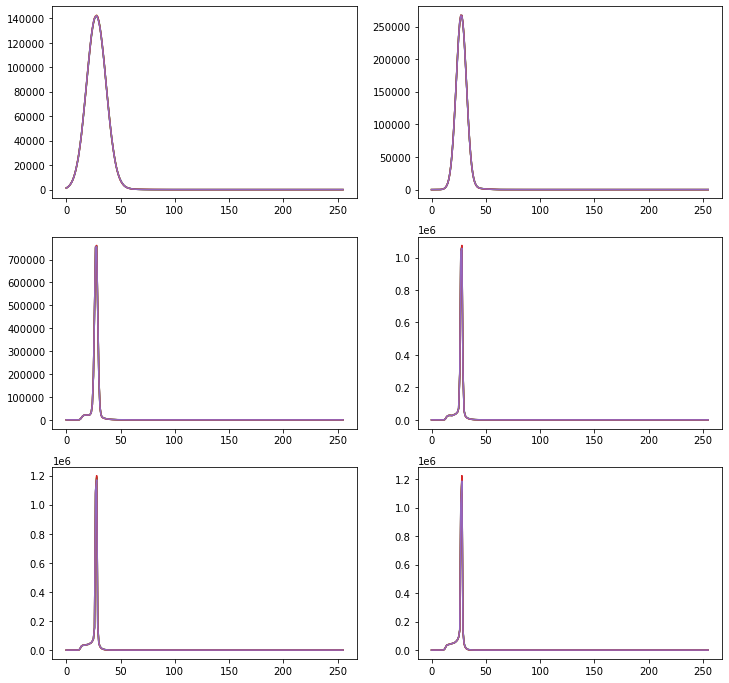

In [176]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
axes = np.ravel(ax)
for j in [0,1,2,3,4,5]:
    for n in range(0, len(histograms)):
        axes[j].plot(histograms[n][j])


### OK, so that's solved: the histograms are extremely similar from independent simulations with the same parameters. This should mean I can pre-compute histograms. That's good. 

In [180]:
a = np.zeros((2,2))
a[0,0] = list([1,2,3,4])

ValueError: setting an array element with a sequence.

In [189]:
np.ndarray((2,2), dtype=list)

array([[None, None],
       [None, None]], dtype=object)

In [186]:
?np.ndarray

Init signature: np.ndarray(self, /, *args, **kwargs)
Docstring:     
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape of created array.
dtype : data-type, optional
    Any object that can be interpreted as a numpy data type.
buffer : object exposing buffer int

In [ ]:
# Write up something to compute histograms for simulations with a range of parameters. 

In [242]:
############################################################################
from flymovie import mesh_like

def compute_simulation_hist(blob_intensity_means=np.arange(0,100,10), 
    blob_numbers=np.arange(0,500,10), bg_mean=28, bg_var=9, blob_intensity_var=3, 
    blob_radius_mean=1, blob_radius_var=0.8, sigma_range=np.arange(0,4,0.25), 
    hist_range=np.arange(0,256,2.5)):

    def make_mask():
        mask = np.zeros((10, 200, 200)) # 40, 1000, 1000
        z, i, j = mesh_like(mask, 3)
        z_midpoint = int(mask.shape[0] / 2)
        rad = 50
        nuc_id = 1
        for i_center in range(100, mask.shape[1], 200):
            for j_center in range(100, mask.shape[2], 200):
                mask[(((z - z_midpoint) ** 2) + ((i - i_center) ** 2) + ((j - j_center) ** 2)) < (rad ** 2)] = nuc_id
                nuc_id += 1
        return mask
    
    mask = make_mask()
    print('Mask made.')
    # hist data structure dims: param1 -> param2 -> ... -> sigma_level -> hist bin

    histograms = np.zeros([len(blob_intensity_means), len(blob_numbers), len(sigma_range), len(hist_range)-1])
    for p1 in range(0, len(blob_intensity_means)):
        print(p1)
        for p2 in range(0, len(blob_numbers)):
            print(p2, end=' ')
            blob_intensity_mean = blob_intensity_means[p1]
            blob_number = blob_numbers[p2]

            sim = simulate(mask, blob_intensity_mean=blob_intensity_mean, 
            blob_number=blob_number, bg_mean=28, bg_var=9, blob_intensity_var=3, 
            blob_radius_mean=1, blob_radius_var=0.8)
            
            sim_scalespace = make_scalespace(sim, sigma_range)
            for sigma_layer in range(0, sim_scalespace.shape[0]):
                hist = np.histogram(sim_scalespace[sigma_layer][np.where(mask)], bins=hist_range)[0]
                histograms[p1, p2, sigma_layer] = hist
        
    return histograms
                
histograms = compute_simulation_hist()
        



Mask made.
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 5
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 6
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

In [251]:
fm.save_pickle(histograms, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210919-simmedhistograms.pkl')

In [218]:
len(np.arange(0,256,5))

52

In [247]:
fm.viewer(histograms)

interactive(children=(Dropdown(description='Color', index=5, options=('magma', 'Reds', 'Gators', 'viridis', 'G…

In [246]:
?sys.getsizeof

Docstring:
getsizeof(object [, default]) -> int

Return the size of object in bytes.
Type:      builtin_function_or_method


In [250]:
from dask import delayed, compute
import dask

@delayed
def square(num):
    print("square fn:", num)
    print()
    return num * num

@delayed
def sum_list(args):
    print("sum_list fn:", args)
    return sum(args)

items = [1, 2, 3]

computation_graph = sum_list([square(i) for i in items])

computation_graph.visualize()

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.

In [2]:
import cv2 as cv
comp_val = cv.compareHist(hist1.astype('float32'), hist2.astype('float32'), method=method)

NameError: name 'hist1' is not defined